# Importing All Required Packages 

In [1]:
#mporting packages
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR =r"E:\Masked-RCNN"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = r"E:\Masked-RCNN\logs\object20220101T0927\mask_rcnn_object_0019.h5" 

Using TensorFlow backend.


# Custom config class for parameters 

In [11]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1 #for inference we are using 1 here at the time of training I have used 2 

    NUM_CLASSES = 1 + 2  # Background + Car and truck

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

# Custom dataset class for data preparation for testing 

In [12]:
# Code for Customdataset class. Same code is present in custom.py file also
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        #I am using 2 classes thats why car and truck we can add more classes as per our requirement
        self.add_class("object", 1, "Car")
        self.add_class("object", 2, "Truck")


        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open('{}/{}_json.json'.format(dataset_dir,subset)))

        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Car": 1,"tab": 2,"Truck": 3}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [13]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = r"E:\Masked-RCNN\Dataset"


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = r"E:\Masked-RCNN\Dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


objects: ['Truck']
numids [3]
objects: ['Car']
numids [1]
objects: ['Truck']
numids [3]
objects: ['Car']
numids [1]
Images: 4
Classes: ['BG', 'Car', 'Truck']


# Loading model

In [5]:
# from keras.backend import manual_variable_initialization 
# manual_variable_initialization(True)

config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Loading weights for model

In [6]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  E:\Masked-RCNN\logs\object20220101T0927\mask_rcnn_object_0019.h5
Re-starting from epoch 19


# Predictions

Images: 4
Classes: ['BG', 'Car', 'Truck']
Processing 1 images
image                    shape: (667, 1000, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (344, 612, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


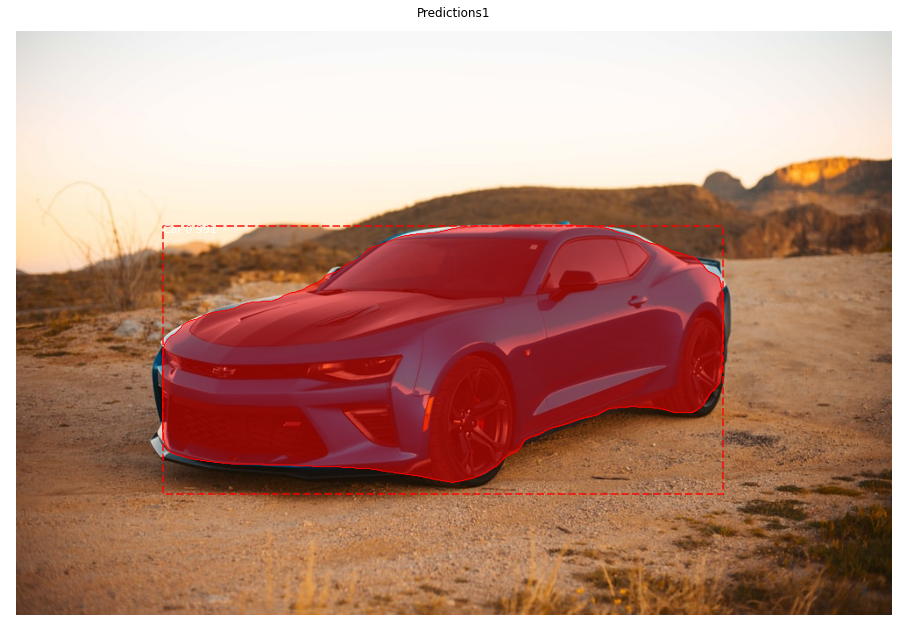

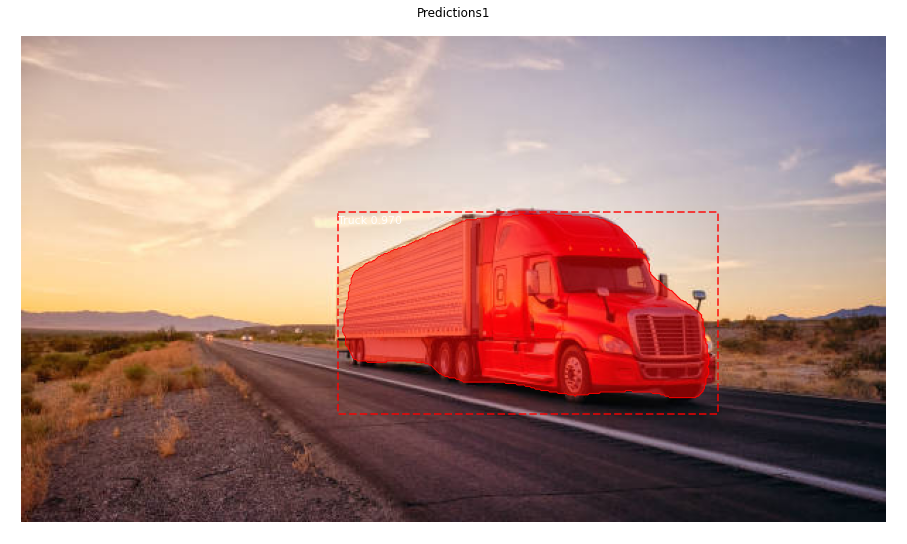

In [10]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# This is for predicting images which are not present in dataset
for path_to_new_image in os.listdir(r"E:\Masked-RCNN\test_data"):
    image1 = mpimg.imread(os.path.join(r"E:\Masked-RCNN\test_data",path_to_new_image))

    # Run object detection
    #print(len([image1]))
    results1 = model.detect([image1], verbose=1)
    #print('result is',results1)
    # Display results
    ax = get_ax(1)
    r1 = results1[0]
    visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
    dataset.class_names, r1['scores'], ax=ax, title="Predictions1")